# Testing ANTSPy against ANTS + Nibabel 

In [1]:
import os
import sys
module_path = os.path.abspath('../utils')
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from deepbrain import Extractor
import ants

from skull_stripping_ants.s3 import *

%load_ext autoreload
%autoreload 2

main_dir = '/home/lucasthim1/alzheimer_data/test/002_S_4270/'
output_path = "/home/lucasthim1/alzheimer_data/test/registration_test/01_affine_s3/"
input_path = "/home/lucasthim1/alzheimer_data/test/002_S_4270/MT1__N3m/2011-10-11_07_59_12.0/S125083/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073.nii"

# Main Functions

In [2]:
def show_slices(slices,img):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    fig.set_size_inches(11,8)
    for i, slice in enumerate(slices):

        axes[i].imshow(slice.T, cmap="gray", origin="lower")
    plt.suptitle(f"Center slices for current MRI image \n Image size: {img.shape}",fontsize=20)
    # print("image size:",img.shape)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.20)
    plt.show()

def show_brain_center_slice(img: np.memmap):
    slice_0 = img[int(img.shape[0]/2), :, :]
    slice_1 = img[:, int(img.shape[1]/2), :]
    slice_2 = img[:, :, int(img.shape[2]/2)]
    show_slices([slice_0, slice_1, slice_2],img)

# img_stripped = img.copy()
# img_stripped[~mask] = 0

In [3]:
def execute_skull_stripping_process(input_path,output_path,skull_stripping_type = 'ANTs'):
    
    set_env_variables()
    start = time.time()

    images_to_process,_,_ = list_available_images(input_path)
    print('------------------------------------------------------------------------------------')
    print(f"Starting {skull_stripping_type} skull stripping process for {len(images_to_process)} images. This might take a while... =)")
    print('------------------------------------------------------------------------------------')
    
    for ii,image_path in enumerate(images_to_process):
        print('\n------------------------------------------------------------------------------------')
        print(f"Processing image ({ii+1}/{len(images_to_process)}):",image_path)
        
        if skull_stripping_type == 'ANTs':
            apply_ants_skull_stripping_to_mri(image_path,output_path)
            print("Deleting useless images (masks, gm,wm, etc)...\n")
            delete_useless_images(output_path)
        elif skull_stripping_type == 'DeepBrain':
            apply_deep_brain_skull_stripping_to_mri(image_path,output_path)
        else:
            raise('Please select a valid skull stripping process.')

    total_time = (time.time() - start) / 60.
    print('-------------------------------------------------------------')
    print('-------------------------------------------------------------')
    print('-------------------------------------------------------------')
    print('All images processed! Process took %.2f min) \n' % total_time)
    print('-------------------------------------------------------------')
    print('-------------------------------------------------------------')
    print('-------------------------------------------------------------')

def list_available_images(input_dir):
    
    '''
    List full path to available images.
    '''

    available_images = []
    print("Looking for MRI raw images in path:",input_dir,'\n')
    
    available_images = list(Path(input_dir).rglob("*.nii"))
    print("Found a total of ",len(available_images)," images.")

    masks_and_wrong_images = list(Path(input_dir).rglob("*[Mm]ask*.nii"))
    print("Found a total of ",len(masks_and_wrong_images)," mask images.")
    
    print("Available images to process: ",len(available_images) - len(masks_and_wrong_images),"\n")
    selected_images = list(set(available_images) - set(masks_and_wrong_images))
    
    return selected_images,available_images,masks_and_wrong_images

def delete_useless_images(input_dir):
    
    available_images = [os.fspath(x) for x in list(Path(input_dir).rglob("*.nii.gz"))]
    if available_images:
        useless_images = [x for x in available_images \
            if "masked_basic" in x \
            or "wm" in x \
            or "gm" in x \
            or "csf" in x \
            or "mask_" in x \
            or "mask." in x ]
        for img in useless_images:
            os.remove(img)

def apply_ants_skull_stripping_to_mri(input_path,output_path):
    if not os.path.exists(output_path):
        print("Creating output path... \n")
        os.makedirs(output_path)

    start = time.time()
    skull_stripper = SkullStripper(input_path, output_path, want_tissues=False, want_atlas=False)
    output_img_path = skull_stripper.strip_skull()
    total_time = (time.time() - start) / 60.
    print('Done with skull stripping! Process took %.2f min) \n' % total_time)

def apply_deep_brain_skull_stripping_to_mri(input_path,output_path,probability = 0.5):
    global_input = input_path
    if not os.path.exists(output_path):
        print("Creating output path... \n")
        os.makedirs(output_path)
    
    start = time.time()
    # load img
    # TODO: maybe replace with antspy because it is faster
    img = nib.load(input_path).get_fdata()

    # execute brain extraction
    ext = Extractor()
    print("Running DeepBrain Skull Stripping...")
    prob = ext.run(img) 
    mask = prob > probability
    
    # apply mask
    final_img = img.copy()
    final_img[~mask] = 0
    final_img_name = os.path.splitext(os.path.splitext(os.path.basename(input_path))[0])[0]
    output_file_path = output_path + '/' + final_img_name + "_masked_deepbrain.nii.gz"
    
    final_img_nii = nib.Nifti1Image(final_img, np.eye(4))
    # final_img_nii.header.get_xyzt_units()
    # final_img_nii.to_filename(output_file_path)
    print('Skull stripped image saved as :',output_file_path)

    total_time = (time.time() - start)
    print('Done with skull stripping! Process took %.2f sec) \n' % total_time)
    return final_img_nii, final_img

In [4]:
def set_env_variables():
    print("Setting ANTs and NiftyReg environment variables...\n")

    os.environ['ANTSPATH'] = '/home/lucasthim1/ants/ants_install/bin'
    os.environ['PATH'] =os.environ['PATH'] +  ":" + os.environ['ANTSPATH']
    os.environ['NIFTYREG_INSTALL'] = '/home/lucasthim1/niftyreg/niftyreg_install'
    os.environ['PATH'] = os.environ['PATH'] +  ":" + os.environ['NIFTYREG_INSTALL'] + '/bin'
set_env_variables()

Setting ANTs and NiftyReg environment variables...



In [5]:
def apply_full_s3_skull_stripping(input_path,output_path):
    if not os.path.exists(output_path):
        print("Creating output path... \n")
        os.makedirs(output_path)

    start = time.time()
    skull_stripper = SkullStripper(input_path, output_path, want_tissues=False, want_atlas=False)
    skull_stripper.strip_skull()
    total_time = (time.time() - start) / 60.
    print('Done! Process took %.2f min)' % total_time)

def apply_skull_stripping(input_path, output_path,type = 'simple'):
    '''
    Skull Stripping Registration procedure for MRI data.

    Arguments:

    input_path: input path of the image to be registered
    
    output_path: output directory to save the registered image

    type: registration type. Values can be ['rigid_refined','affine_refined','simple']
    '''

    input_path = os.path.abspath(input_path)
    if output_path is None:
        output_path = os.path.dirname(os.path.abspath(input_path))
    if not os.path.exists(output_path):
        print("Creating output path... \n")
        os.makedirs(output_path)
    output_path = os.path.abspath(output_path)
    
    start = time.time()
    skull_stripper = SkullStripper(input_path, output_path, want_tissues=True, want_atlas=False)
    if type == 'affine_refined':
        print("Executing Affine S3 Registration... \n")
        skull_stripper.strip_skull()
    elif type == 'rigid_refined':
        print("Executing Rigid Registration... \n")
        skull_stripper.rigid_strip_skull()
    elif type == 'simple':
        print("Executing Simple Rigid Registration... \n")
        skull_stripper.simple_strip_skull()
    elif type == 'test':
        print("Executing Test Registration... \n")
        skull_stripper.test_strip_skull()
    elif type == 'affine_reg':
        print("Executing Affine Registration... \n")
        skull_stripper.affine_registration()
        
    else:
        raise Exception("Please select a valid type of skull stripping registration: ['rigid_refined','affine_refined','simple']")

    print('Done! Process took %.2f min)' % ((time.time() - start) / 60.))
    

# Comparing Results from Early methods

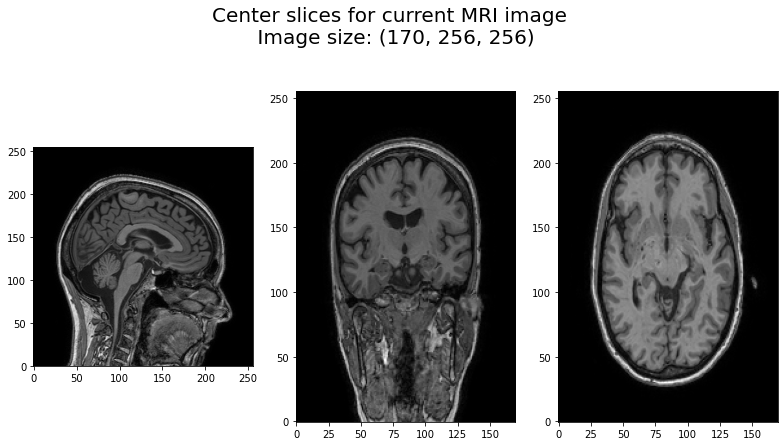

In [27]:
input_path = '/home/lucasthim1/alzheimer_data/test/002_S_4270/MT1__N3m/2011-10-11_07_59_12.0/S125083/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073.nii'
img = nib.load(input_path).get_fdata()
show_brain_center_slice(img)

## Skull stripped image with Deep Brain (.nii.gz)

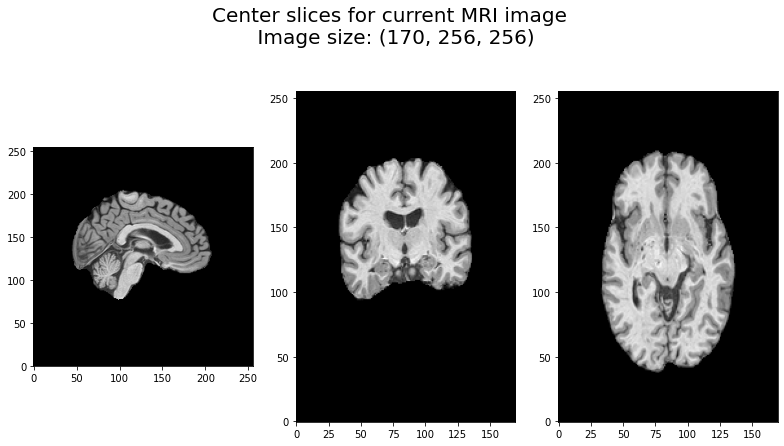

In [28]:
input_path = '/home/lucasthim1/alzheimer_data/test/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073_masked_deepbrain.nii.gz'
img = nib.load(input_path).get_fdata()
show_brain_center_slice(img)

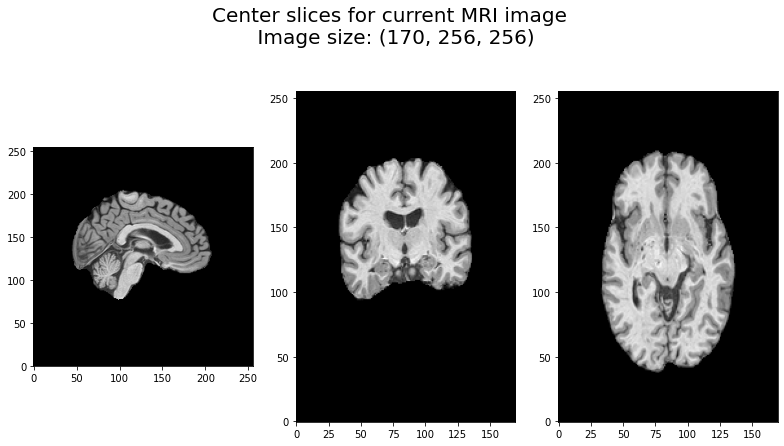

In [32]:
input_path = '/home/lucasthim1/alzheimer_data/test/002_S_4270/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073_masked_deepbrain.nii.gz'
img = nib.load(input_path).get_fdata()
show_brain_center_slice(img)

## Skull stripped and registered image with ANTs (.nii.gz)

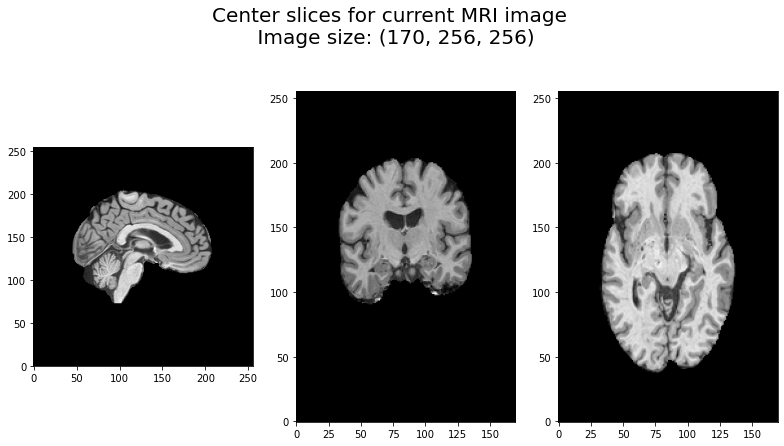

In [30]:
input_path = '/home/lucasthim1/alzheimer_data/test/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073_masked.nii.gz'
img = nib.load(input_path).get_fdata()
show_brain_center_slice(img)

# Testing Regular S3 Affine Registration + skull stripping with .sh file

In [23]:
output_path = "/home/lucasthim1/alzheimer_data/test/registration_test/01_affine_s3/"
apply_skull_stripping(input_path,output_path,type='affine_refined')

Creating output path... 

Executing Affine S3 Registration... 

Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/test/002_S_4270/MT1__N3m/2011-10-11_07_59_12.0/S125083/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073.nii 

Output Folder : /home/lucasthim1/alzheimer_data/registration_test/01_affine_s3 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/alzheimer_data/registration_test/01_affine_s3/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073_csf.nii.gz
gm image is saved to: /home/lucasthim1/alzheimer_data/registration_test/01_affine_s3/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073_gm.nii.gz
wm image is saved to: /home/lucasthim1/alzheimer_data/registration_test/01_affine_s3/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073_wm.nii.gz

Computing refined mask 
 -------------


Function took 3 minutes. 

# Testing just Affine Registration with affine_reg.sh file

No tissue segmentation, just basic mask with affine

In [6]:
set_env_variables()
main_dir = '/home/lucasthim1/alzheimer_data/test/002_S_4270/'
input_path = main_dir + "002_S_4225/MT1__N3m/2011-09-21_10_09_36.0/S122881/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686.nii"
output_path = "/home/lucasthim1/alzheimer_data/test/registration_test/02_affine_reg/"


Setting ANTs and NiftyReg environment variables...



In [8]:
output_path = "/home/lucasthim1/alzheimer_data/test/registration_test/02_affine_reg/"
apply_skull_stripping(input_path,output_path,type='affine_reg')

Executing Affine Registration... 

Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/alzheimer_data/test/002_S_4270/002_S_4225/MT1__N3m/2011-09-21_10_09_36.0/S122881/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686.nii 

Output Folder : /home/lucasthim1/alzheimer_data/test/registration_test/02_affine_reg 


Compute basic mask: 
 -----------------


FileNotFoundError: No such file or no access: '/home/lucasthim1/alzheimer_data/test/registration_test/02_affine_reg/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686_mask.nii.gz'

In [5]:

input_path = '/home/lucasthim1/alzheimer_data/test/002_S_4270/MT1__N3m/2011-10-11_07_59_12.0/S125083/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073.nii'
img = nib.load(input_path).get_fdata()
show_brain_center_slice(img)

# Testing Registration with ANTsPy

In [10]:
set_env_variables()
input_path = '/home/lucasthim1/alzheimer_data/test/002_S_4270/MT1__N3m/2011-10-11_07_59_12.0/S125083/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073.nii'
output_path = "/home/lucasthim1/alzheimer_data/test/registration_test/02_affine_reg/"


Setting ANTs and NiftyReg environment variables...



In [14]:
moving = ants.image_read(input_path)
fixed = ants.image_read('/home/lucasthim1/alzheimer_data/Atlas/atlas_t1.nii')

/home/lucasthim1/miniconda3/envs/alzheimer/lib/python3.8/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



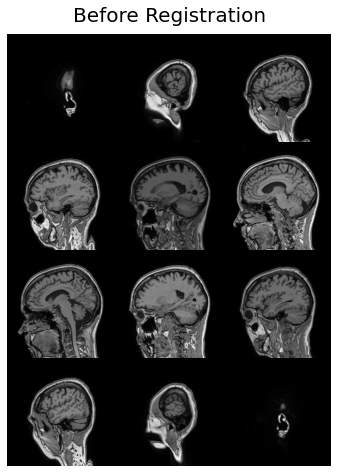

In [18]:
moving.plot(title='Before Registration')

## Simple SyN registration

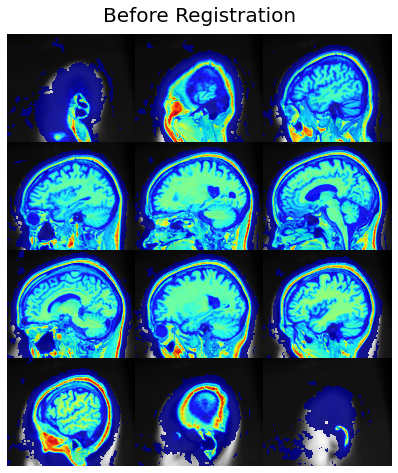

{'warpedmovout': ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (193, 229, 193)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (96.0, 132.0, -78.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]
, 'warpedfixout': ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (170, 256, 256)
	 Spacing    : (1.2, 1.0, 1.0)
	 Origin     : (125.6703, 148.9712, -93.6403)
	 Direction  : [-0.9851 -0.0142 -0.1712  0.0276 -0.9967 -0.0761 -0.1696 -0.0797  0.9823]
, 'fwdtransforms': ['/tmp/tmpydmhshew1Warp.nii.gz', '/tmp/tmpydmhshew0GenericAffine.mat'], 'invtransforms': ['/tmp/tmpydmhshew0GenericAffine.mat', '/tmp/tmpydmhshew1InverseWarp.nii.gz']}


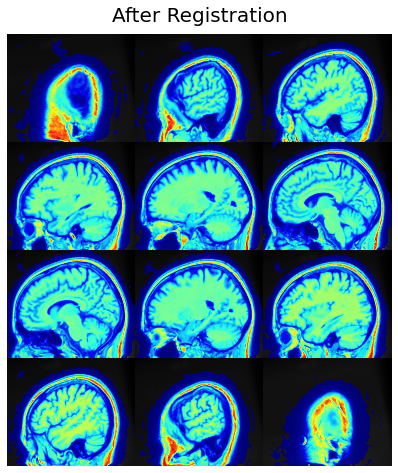

In [15]:
fixed.plot(overlay=moving, title='Before Registration')
mytx = ants.registration(fixed=fixed , moving=moving, type_of_transform='SyN' )
print(mytx)
warped_moving = mytx['warpedmovout']
fixed.plot(overlay=warped_moving,
           title='After Registration')

/home/lucasthim1/miniconda3/envs/alzheimer/lib/python3.8/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



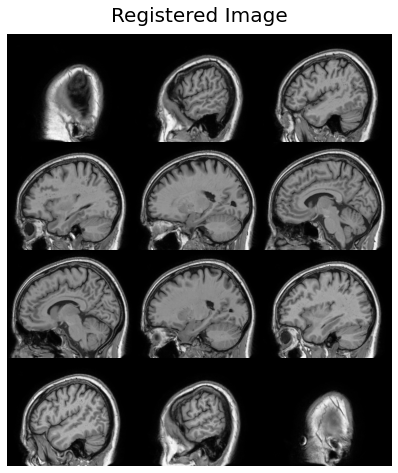

In [20]:
mywarpedimage = ants.apply_transforms(fixed=fixed, moving=moving,
                                      transformlist=mytx['fwdtransforms'])

mywarpedimage.plot(title='Registered Image')

## Affine Registration

/home/lucasthim1/miniconda3/envs/alzheimer/lib/python3.8/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



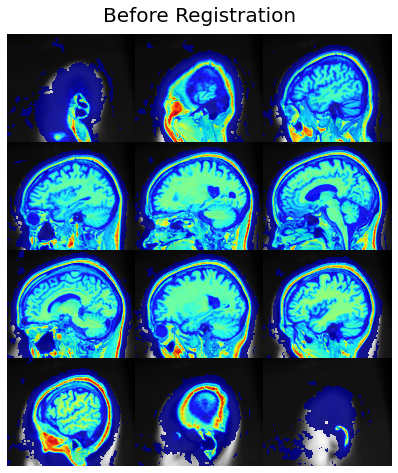

{'warpedmovout': ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (193, 229, 193)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (96.0, 132.0, -78.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]
, 'warpedfixout': ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (170, 256, 256)
	 Spacing    : (1.2, 1.0, 1.0)
	 Origin     : (125.6703, 148.9712, -93.6403)
	 Direction  : [-0.9851 -0.0142 -0.1712  0.0276 -0.9967 -0.0761 -0.1696 -0.0797  0.9823]
, 'fwdtransforms': ['/tmp/tmp9dd396o30GenericAffine.mat'], 'invtransforms': ['/tmp/tmp9dd396o30GenericAffine.mat']}


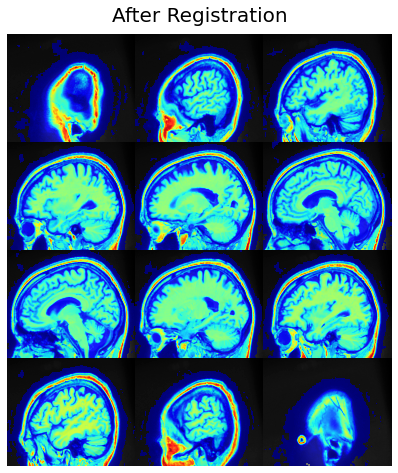

In [26]:
fixed.plot(overlay=moving, title='Before Registration')
mytx = ants.registration(fixed=fixed , moving=moving, type_of_transform='Affine' ,grad_step=0.1)
print(mytx)
warped_moving = mytx['warpedmovout']
fixed.plot(overlay=warped_moving,
           title='After Registration')

/home/lucasthim1/miniconda3/envs/alzheimer/lib/python3.8/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



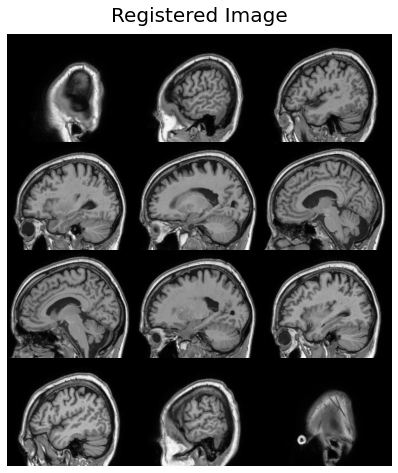

In [27]:
mywarpedimage = ants.apply_transforms(fixed=fixed, moving=moving,
                                      transformlist=mytx['fwdtransforms'])

mywarpedimage.plot(title='Registered Image')

## Similarity Registration

/home/lucasthim1/miniconda3/envs/alzheimer/lib/python3.8/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



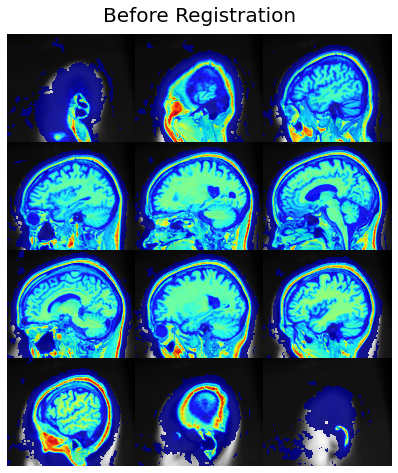

{'warpedmovout': ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (193, 229, 193)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (96.0, 132.0, -78.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]
, 'warpedfixout': ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (170, 256, 256)
	 Spacing    : (1.2, 1.0, 1.0)
	 Origin     : (125.6703, 148.9712, -93.6403)
	 Direction  : [-0.9851 -0.0142 -0.1712  0.0276 -0.9967 -0.0761 -0.1696 -0.0797  0.9823]
, 'fwdtransforms': ['/tmp/tmpvjyuiywm0GenericAffine.mat'], 'invtransforms': ['/tmp/tmpvjyuiywm0GenericAffine.mat']}


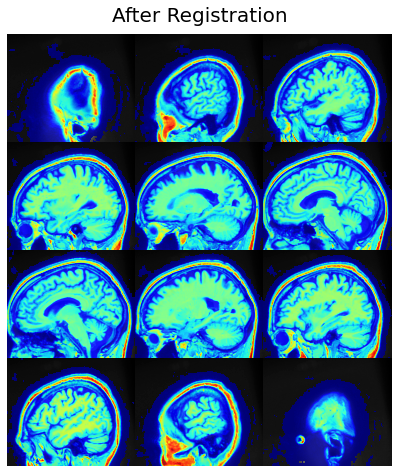

In [28]:
fixed.plot(overlay=moving, title='Before Registration')
mytx = ants.registration(fixed=fixed , moving=moving, type_of_transform='Similarity' ,grad_step=0.1)
print(mytx)
warped_moving = mytx['warpedmovout']
fixed.plot(overlay=warped_moving,
           title='After Registration')

/home/lucasthim1/miniconda3/envs/alzheimer/lib/python3.8/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



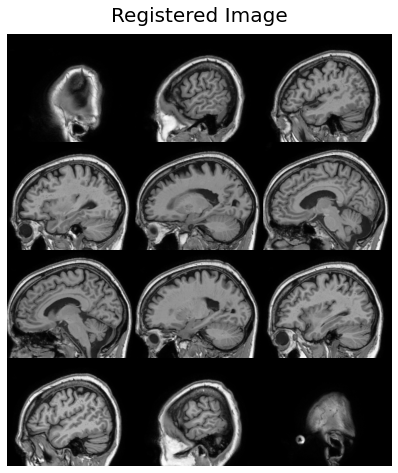

In [29]:
mywarpedimage = ants.apply_transforms(fixed=fixed, moving=moving,
                                      transformlist=mytx['fwdtransforms'])

mywarpedimage.plot(title='Registered Image')

# Testing Registration with ANTsPy + DeepBrain skull stripping

In [6]:
set_env_variables()
input_path = '/home/lucasthim1/alzheimer_data/test/002_S_4270/MT1__N3m/2011-10-11_07_59_12.0/S125083/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073.nii'
output_path = "/home/lucasthim1/alzheimer_data/test/registration_test/03_similarity_reg/"

Setting ANTs and NiftyReg environment variables...



In [22]:
moving = ants.image_read(input_path)
fixed = ants.image_read('/home/lucasthim1/alzheimer_data/Atlas/atlas_t1.nii')

In [34]:
mytx = ants.registration(fixed=fixed , moving=moving, type_of_transform='Affine' ,grad_step=0.1)
warpedimage = ants.apply_transforms(fixed=fixed, moving=moving, transformlist=mytx['fwdtransforms'])


In [35]:
start = time.time()

img = warpedimage.numpy()
probability = 0.5

# execute brain extraction
ext = Extractor()
print("Running DeepBrain Skull Stripping...")
prob = ext.run(img) 
mask = prob > probability

# apply mask
final_img = img.copy()
final_img[~mask] = 0
final_img_name = os.path.splitext(os.path.splitext(os.path.basename(input_path))[0])[0]
output_file_path = output_path + '/' + final_img_name + "_masked_deepbrain.nii.gz"

final_img_nii = nib.Nifti1Image(final_img, np.eye(4))
final_img_ants = ants.from_numpy(final_img)
# final_img_nii.header.get_xyzt_units()
# final_img_nii.to_filename(output_file_path)
print('Skull stripped image saved as :',output_file_path)

total_time = (time.time() - start)
print('Done with skull stripping! Process took %.2f sec) \n' % total_time)

Running DeepBrain Skull Stripping...
Skull stripped image saved as : /home/lucasthim1/alzheimer_data/test/registration_test/03_similarity_reg//ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073_masked_deepbrain.nii.gz
Done with skull stripping! Process took 2.43 sec) 



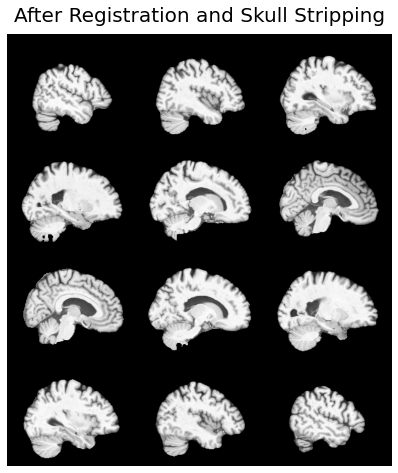

In [36]:
final_img_ants = ants.from_numpy(final_img)
final_img_ants.plot(title='After Registration and Skull Stripping')

/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



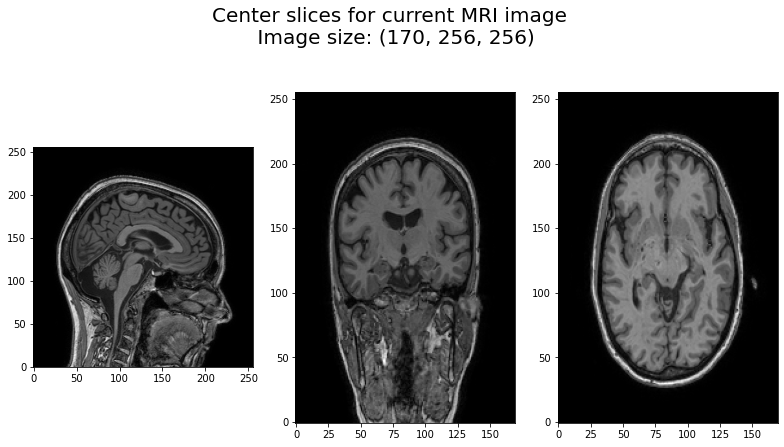

In [26]:
show_brain_center_slice(moving.numpy())

/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



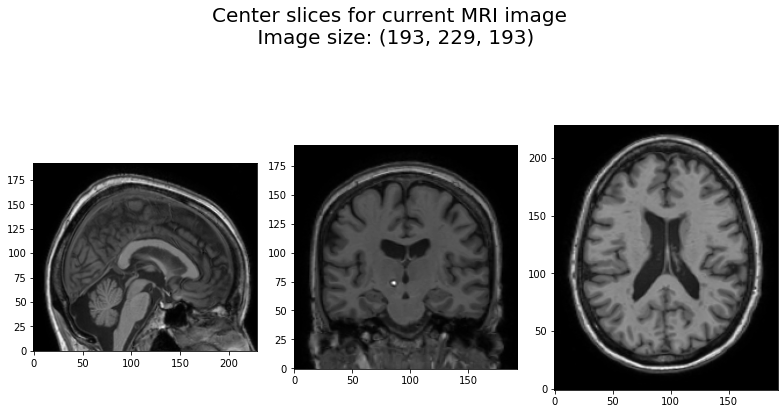

In [37]:
show_brain_center_slice(warpedimage.numpy())

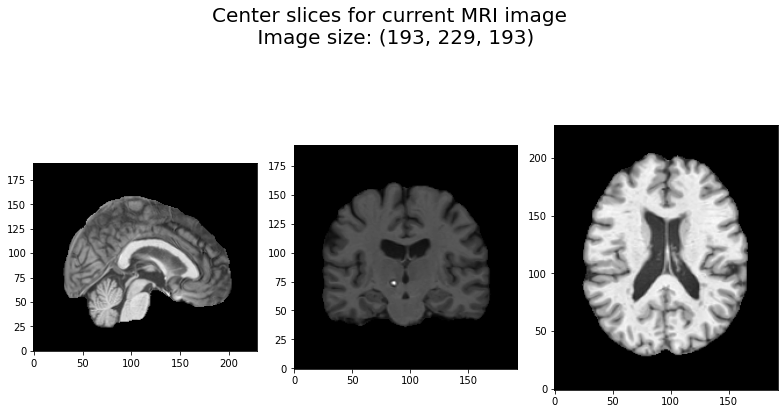

In [38]:
show_brain_center_slice(final_img)

# Checking a different image with ANTsPy + DeepBrain

In [47]:
input_path = "/home/lucasthim1/alzheimer_data/test/011_S_4366/MT1__GradWarp__N3m/2011-11-14_15_42_54.0/S129365/ADNI_011_S_4366_MR_MT1__GradWarp__N3m_Br_20111121112859085_S129365_I267763.nii"
moving = ants.image_read(input_path)
fixed = ants.image_read('/home/lucasthim1/alzheimer_data/Atlas/atlas_t1.nii')
mytx = ants.registration(fixed=fixed , moving=moving, type_of_transform='Affine' ,grad_step=0.1)
warpedimage = ants.apply_transforms(fixed=fixed, moving=moving, transformlist=mytx['fwdtransforms'])


/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [48]:
start = time.time()

img = warpedimage.numpy()
probability = 0.5

# execute brain extraction
ext = Extractor()
print("Running DeepBrain Skull Stripping...")
prob = ext.run(img) 
mask = prob > probability

# apply mask
final_img = img.copy()
final_img[~mask] = 0
final_img_name = os.path.splitext(os.path.splitext(os.path.basename(input_path))[0])[0]
output_file_path = output_path + '/' + final_img_name + "_masked_deepbrain.nii.gz"

final_img_nii = nib.Nifti1Image(final_img, np.eye(4))
final_img_ants = ants.from_numpy(final_img)
# final_img_nii.header.get_xyzt_units()
# final_img_nii.to_filename(output_file_path)
print('Skull stripped image saved as :',output_file_path)

total_time = (time.time() - start)
print('Done with skull stripping! Process took %.2f sec) \n' % total_time)

Running DeepBrain Skull Stripping...
Skull stripped image saved as : /home/lucasthim1/alzheimer_data/test/registration_test/03_similarity_reg//ADNI_011_S_4366_MR_MT1__GradWarp__N3m_Br_20111121112859085_S129365_I267763_masked_deepbrain.nii.gz
Done with skull stripping! Process took 2.37 sec) 



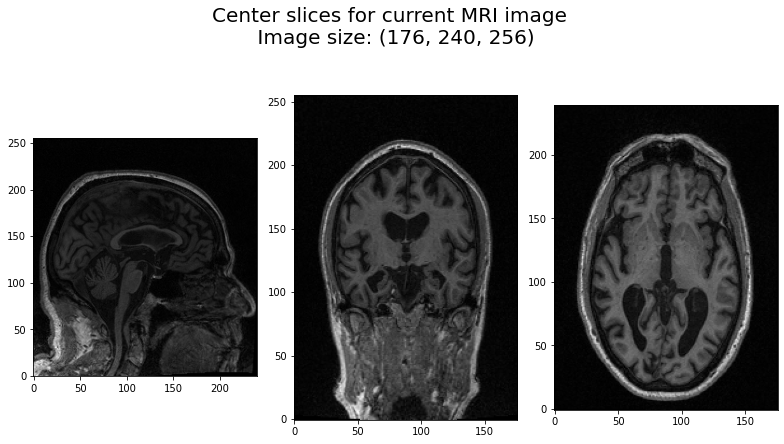

In [61]:
show_brain_center_slice(moving.numpy())

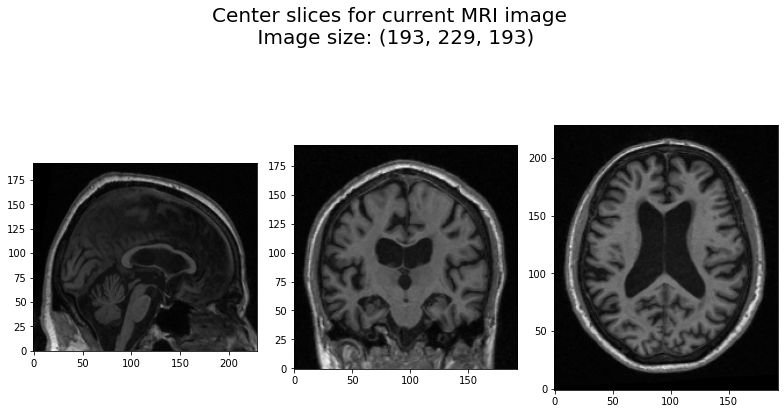

In [62]:
show_brain_center_slice(warpedimage.numpy())

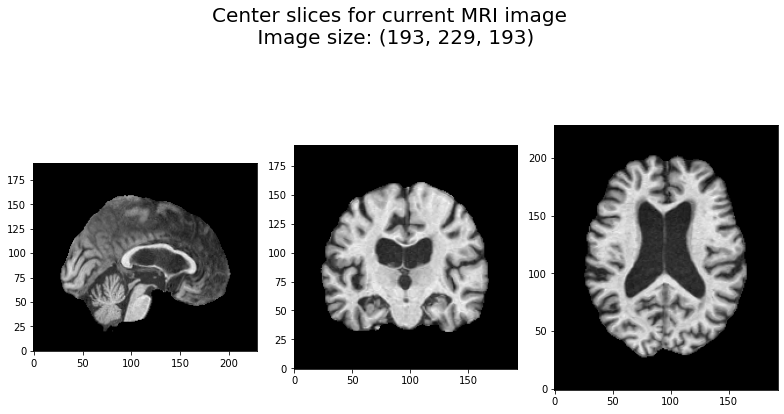

In [63]:
show_brain_center_slice(final_img)

/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



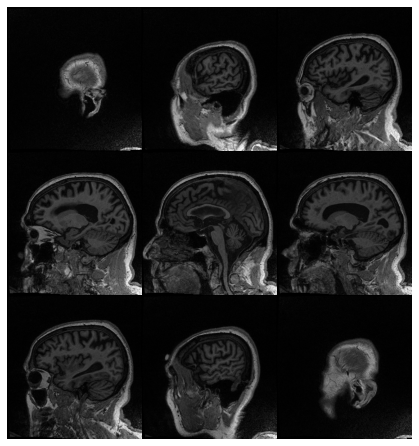

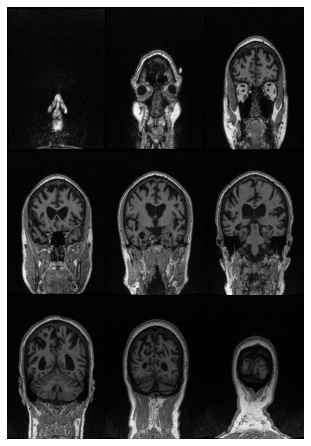

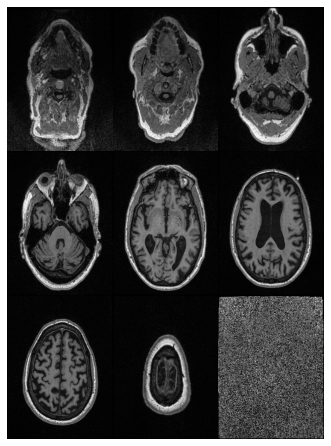

In [55]:
moving.plot(axis =0,figsize=2,nslices=9)
moving.plot(axis =1,figsize=2,nslices=9)
moving.plot(axis =2,figsize=2,nslices=9)

/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



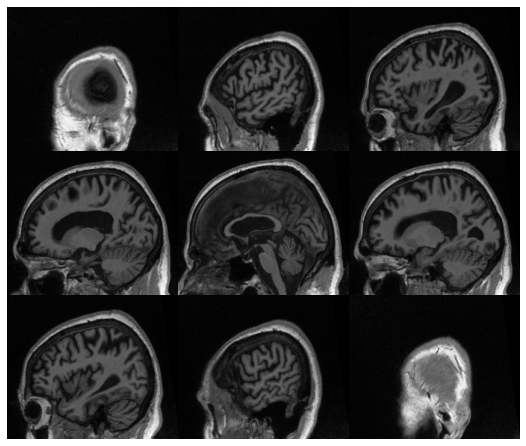

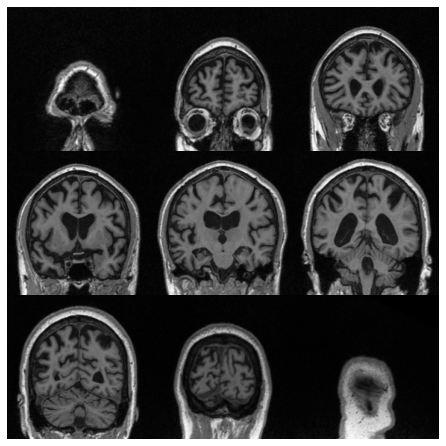

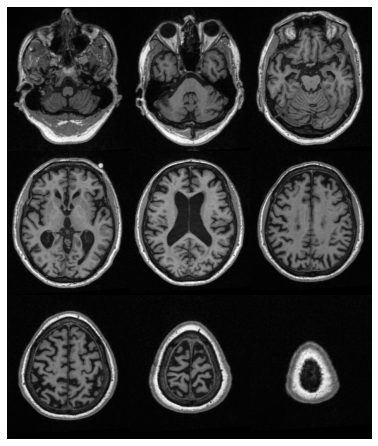

In [56]:
warpedimage.plot(axis =0,figsize=2,nslices=9)
warpedimage.plot(axis =1,figsize=2,nslices=9)
warpedimage.plot(axis =2,figsize=2,nslices=9)

In [60]:
final_img_ants.numpy().shape

/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(193, 229, 193)

/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



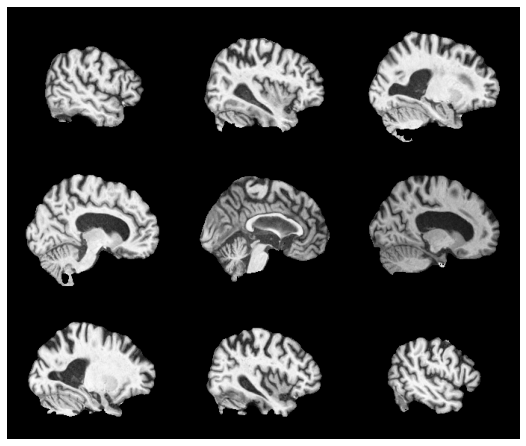

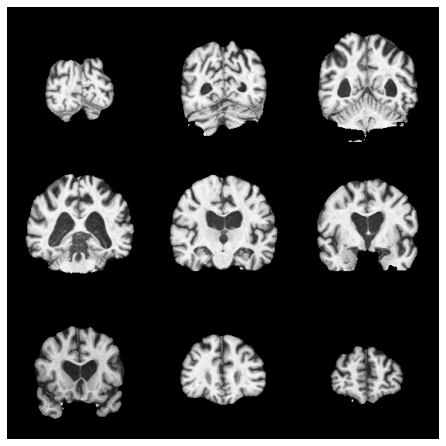

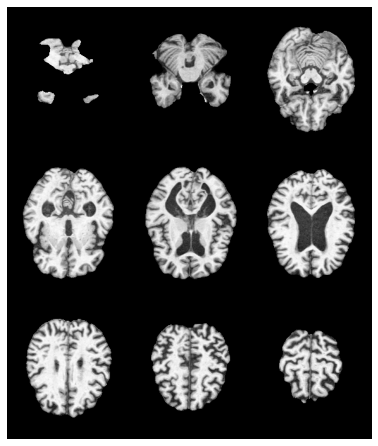

In [57]:
final_img_ants.plot(axis =0,figsize=2,nslices=9)
final_img_ants.plot(axis =1,figsize=2,nslices=9)
final_img_ants.plot(axis =2,figsize=2,nslices=9)

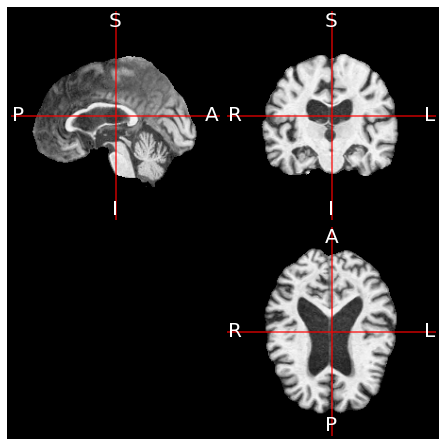

In [59]:
final_img_ants.plot_ortho()

# Checking ATLAS

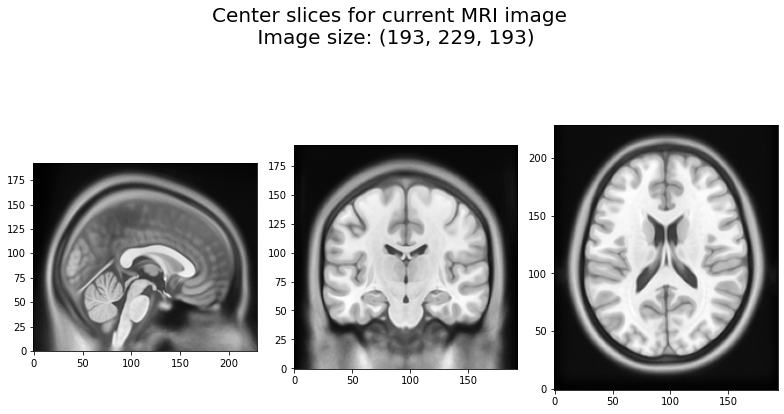

In [72]:
atlas = '/home/lucasthim1/mmml-alzheimer-diagnosis/src/playground/utils/s3/Atlas/atlas_t1.nii'
atlas_img = nib.load(atlas).get_fdata()
show_brain_center_slice(atlas_img)

In [40]:
# atlas_dir = '/home/lucasthim1/alzheimer_bucket/atlas/ICBM152_2009a_nonlinear_symmetric/'
# os.listdir(atlas_dir)
# atlas =atlas_dir + 'mni_icbm152_t1_tal_nlin_sym_09a.nii'
# atlas_img = nib.load(atlas).get_fdata()
# show_brain_center_slice(atlas_img)